In [2]:
# pip install --upgrade pystac-client

In [2]:
# pip show pystac_client
%pip install terracatalogueclient

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement terracatalogueclient (from versions: none)
ERROR: No matching distribution found for terracatalogueclient


In [4]:
# imports
import pystac_client
import xarray as xr
import matplotlib.pyplot as plt
import pathlib
import os
import numpy as np
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm

import webbrowser
from pathlib import Path
import os
import time


In [5]:
# opening STAC catalog, either a url, cloud storage link or a local (cloned) folder
cwd = pathlib.Path().resolve()

catalog = pystac_client.Client.open(
    "https://services.terrascope.be/stac/" # cloud API
    #os.path.join(os.path.dirname(cwd), "stac_folder", "current", "catalog.json") # local clone 
)
catalog

<Client id=terrascope>

In [6]:
list(catalog.get_children())

[<CollectionClient id=urn:eop:VITO:CGS_S1_GRD_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S1_GRD_SIGMA0_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S1_SLC_L1>,
 <CollectionClient id=urn:eop:VITO:CGS_S2_L1C>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_EU_25M>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_GLO_30M_COG>,
 <CollectionClient id=urn:eop:VITO:COP_DEM_GLO_90M_COG>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_ACTIVECROPLAND_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_IRRIGATION_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_MAIZE_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_SPRINGCEREALS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_TEMPORARYCROPS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WORLDCEREAL_WINTERCEREALS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2020_V1>,
 <CollectionClient id=urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2>,
 <CollectionCli

In [7]:
collection= catalog.get_child("urn:eop:VITO:COP_DEM_GLO_30M_COG")
collection

<CollectionClient id=urn:eop:VITO:COP_DEM_GLO_30M_COG>

In [8]:
# b=list(catalog.get_collections())
# for collec in b:
#     print(f"{collec.id}")

In [9]:
items=list(collection.get_all_items())
print(f"Number of items: {len(items)}")
for item in items:
    print(f"- {item.id}")

Number of items: 100
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E006_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E009_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E010_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E011_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E012_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E013_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E014_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E015_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E016_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E017_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E018_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E019_00_DEM
- urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_E02

In [10]:
# World cover goes up in increments of 3 degrees

import math
tile_size=1
tile_prefix="urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_"
decimal_zero="_00_"
tile_suffix="_00_DEM"

 


def find_tile_name(lat,lon,tile_size,tile_prefix):
    if lon>0:
        sign_lon="E"
    else:
        sign_lon="W"
    if lat>0:
        sign_lat="N"
    else:
        sign_lat="S"
    if abs(lat)<10:
        newlat="0"+str(abs(math.floor(lat/tile_size)*tile_size))
    else:
        newlat=str(abs(math.floor(lat/tile_size)*tile_size))
    if abs(lon)<100:
        newlon="0"+str(abs(math.floor(lon/tile_size)*tile_size))
    else:
        newlon=str(abs(math.floor(lon/tile_size)*tile_size))
    tile_name=tile_prefix+ sign_lat+newlat+decimal_zero+sign_lon+newlon+tile_suffix
    return tile_name

# urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N00_00_W075_00_DEM
#  eg item_id="ESA_WorldCover_10m_2020_v100_S57W072"


In [11]:
collection.get_item("urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N12_00_W070_00_DEM").assets["DEM"].href

'https://services.terrascope.be/download/DEM/COPERNICUS-DEM-30/Copernicus_DSM_COG_10_N12_00_W070_00_DEM/Copernicus_DSM_COG_10_N12_00_W070_00_DEM.tif'

In [23]:
from rasterio.session import AWSSession

lon_x=-69.07256	
lat_y=12.18975	

# Define the AWS session
aws_session = rasterio.session.AWSSession(aws_unsigned=True, region_name='us-west-1')


tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)
tile_name

href = collection.get_item(tile_name).assets["DEM"].href

#Workaround by downloading from terrascope
webbrowser.open(href)

# Pause execution for 2 seconds
time.sleep(.5)

#Open from downloads
file_path = Path.home().joinpath("Downloads", href[-44:])

COP_DEM_xr = xr.open_dataset(file_path, engine="rasterio", mask_and_scale=False)

COP_DEM_xr





<xarray.Dataset>
Dimensions:      (band: 1, x: 3600, y: 3600)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -70.0 -70.0 -70.0 -70.0 ... -69.0 -69.0 -69.0 -69.0
  * y            (y) float64 13.0 13.0 13.0 13.0 13.0 ... 12.0 12.0 12.0 12.0
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

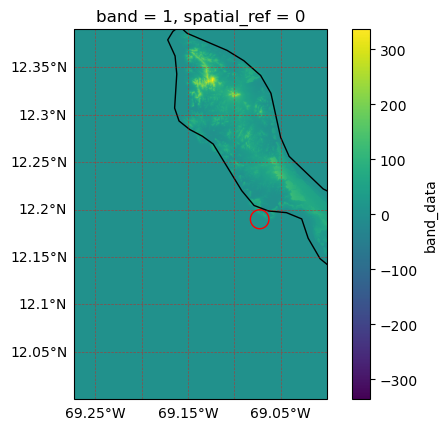

In [24]:
# Create a map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable
COP_DEM_xr["band_data"].sel(x=slice(lon_x-.2,lon_x+.2),y=slice(lat_y+.2,lat_y-.2)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')

# Add features like coastlines, borders, and ocean
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')
# ax.add_feature(cartopy.feature.OCEAN)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='red', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


# Create a point geometry
point = Point(lon_x, lat_y)

# Create a GeoDataFrame from the point
gdf = gpd.GeoDataFrame(geometry=[point])

# Add a  1000m buffer around the point
gdf['geometry'] = gdf['geometry'].buffer(.01)

# Define the projection
crs = "EPSG:4326"  # WGS84
gdf.set_crs(crs, inplace=True)

# Plot the GeoDataFrame
# fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
gdf.plot(ax=ax, color='none', edgecolor='red')
# Plot the variable


# Show the plot
plt.show()



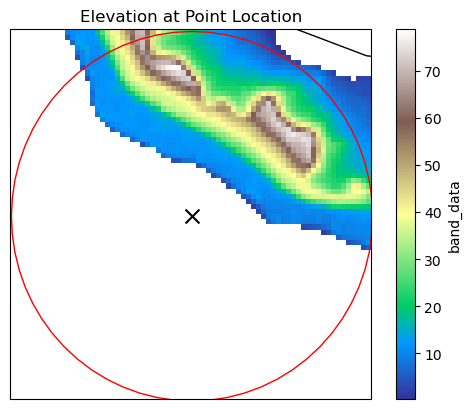

In [25]:

search_square=COP_DEM_xr["band_data"].sel(x=slice(lon_x-.01,lon_x+.01),y=slice(lat_y+.01,lat_y-.01))

search_square.values = np.where(search_square.values > 0, search_square.values, np.nan)




# Create a new Axes for the Colorbar
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', edgecolor='black')


search_square.plot(ax=ax, cmap='terrain')

point = Point(lon_x, lat_y)

# Create a GeoDataFrame from the point
gdf = gpd.GeoDataFrame(geometry=[point])
gdf2 = gpd.GeoDataFrame(geometry=[point])

# Add a 1000m = 0.01degrees buffer around the point
gdf['geometry'] = gdf['geometry'].buffer(.01)

# Define the projection
crs = "EPSG:4326"  # WGS84
gdf.set_crs(crs, inplace=True)
gdf2.set_crs(crs, inplace=True)

gdf2.plot(ax=ax, color='black', marker='x', markersize=100)  # Create a point geometry
gdf.plot(ax=ax, color='none', edgecolor='red')  # Create a point geometry
plt.title("Elevation at Point Location")
plt.show()

# # Close the xarray dataset if it's still open
COP_DEM_xr.close()

# # Delete the file
os.remove(file_path)

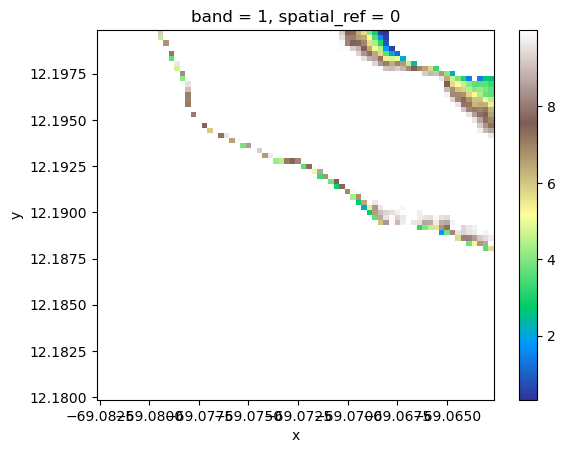

In [26]:
#Visualizing methodology
Lower_mask=0 
Upper_mask= 10
tile_size=1

search_radius=0.01 #Degress=1000m

tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


href = collection.get_item(tile_name).assets["DEM"].href

#Workaround by downloading from terrascope
webbrowser.open(href)

# Pause execution for 2 seconds
time.sleep(.5)

#Open from downloads
file_path = Path.home().joinpath("Downloads", href[-44:])

COP_DEM_xr = xr.open_dataset(file_path, engine="rasterio", mask_and_scale=False)

search_square=COP_DEM_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))




LECZ_values = np.where((search_square.values >Lower_mask) & (search_square.values <= Upper_mask), search_square.values, np.nan)
LECZ_values_da = xr.DataArray(LECZ_values, coords=search_square.coords, dims=search_square.dims)



# Plot the modified data array
LECZ_values_da.plot(cmap='terrain')

# # Close the xarray dataset if it's still open
COP_DEM_xr.close()

# # Delete the file
os.remove(file_path)



In [30]:
# Calculating Pixel sizes
tile_name="urn:eop:VITO:COP_DEM_GLO_30M_COG:Copernicus_DSM_COG_10_N38_00_W096_00_DEM"
href = collection.get_item(tile_name).assets["DEM"].href

#Workaround by downloading from terrascope
webbrowser.open(href)

# Pause execution for 2 seconds
time.sleep(5)

#Open from downloads
file_path = Path.home().joinpath("Downloads", href[-44:])

COP_DEM_xr = xr.open_dataset(file_path, engine="rasterio", mask_and_scale=False)


x_coords = COP_DEM_xr.coords['x']
y_coords = COP_DEM_xr.coords['y']

# Calculate the pixel size
x_pixel_size = x_coords[1].values - x_coords[0].values
y_pixel_size = y_coords[1].values - y_coords[0].values

pixel_area_deg=x_pixel_size*y_pixel_size

# # Close the xarray dataset if it's still open
COP_DEM_xr.close()

# # Delete the file
os.remove(file_path)

pixel_area_deg

-7.716049382767804e-08

In [31]:
import utm

def degrees_squared_to_m2(lat1, lon1,lat2, lon2):
    # Calculate UTM zone for the given latitude and longitude
    utm_zone = utm.from_latlon(lat1, lon1)[2]

    # Get UTM projection parameters
    utm_params1 = utm.from_latlon(lat1, lon1)
    utm_params2 = utm.from_latlon(lat2, lon2)

    dist_lat= abs(utm_params1[0]-utm_params2[0])
    dist_lon= abs(utm_params1[1]-utm_params2[1])

    pixel_area_m2=dist_lat*dist_lon

    return  pixel_area_m2

# Example usage:
ds=COP_DEM_xr
lat1=ds.coords['y'][0].values
lon1=ds.coords['x'][0].values
lat2=ds.coords['y'][1].values
lon2=ds.coords['x'][1].values


pixel_area_m2 = degrees_squared_to_m2(lat1, lon1,lat2, lon2)
print("Pixel Area in square meters:", pixel_area_m2)


Pixel Area in square meters: 728.8065421605049


In [32]:
#Visualizing methodology
Lower_mask=0 
Upper_mask= 10
tile_size=1
search_radius=0.01 #Degrees=1000m


tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)


href = collection.get_item(tile_name).assets["DEM"].href

#Workaround by downloading from terrascope
webbrowser.open(href)

# Pause execution for 2 seconds to allow download to complete
time.sleep(2)

#Open from downloads
file_path = Path.home().joinpath("Downloads", href[-44:])

COP_DEM_xr = xr.open_dataset(file_path, engine="rasterio", mask_and_scale=False)

search_square=COP_DEM_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))


LECZ_values = np.where((search_square.values >Lower_mask) & (search_square.values <= Upper_mask), search_square.values, np.nan)
NON_LECZ_values = np.where(~((search_square.values >Lower_mask) & (search_square.values <= Upper_mask)), search_square.values, np.nan)

if np.isnan(LECZ_values).all() & ~np.isnan(NON_LECZ_values).all():
    LECZ_area_per_LECZ_mean_elev=-1995 #Cliff ie very high values, no low elevations
    # continue
elif np.isnan(LECZ_values).all():
    LECZ_area_per_LECZ_mean_elev=np.nan #all water I guess
    # continue
elif ~np.isnan(LECZ_values).all():
    #Calculate m2 per pixel for that area
    ds=search_square
    lat1=ds.coords['y'][0].values
    lon1=ds.coords['x'][0].values
    lat2=ds.coords['y'][1].values
    lon2=ds.coords['x'][1].values


    pixel_area_m2 = degrees_squared_to_m2(lat1, lon1,lat2, lon2)

    LECZ_pixel_count=np.count_nonzero(~np.isnan(LECZ_values))
    LECZ_AREA_m2=LECZ_pixel_count*pixel_area_m2

    LECZ_mean_elev=np.nanmean(LECZ_values)

    LECZ_area_per_LECZ_mean_elev=LECZ_AREA_m2/LECZ_mean_elev


# # Close the xarray dataset if it's still open
COP_DEM_xr.close()

# # Delete the file
os.remove(file_path)

LECZ_area_per_LECZ_mean_elev

37098.319954783794

In [33]:
template_df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Arjen_Vector_Template_Netherland_Antilles.csv")
template_df.head()

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136


In [34]:

template_df["Pixel_AREA_m2"]=np.nan
template_df["LECZ_AREA_m2"]=np.nan
template_df["LECZ_mean_elev"]=np.nan
template_df["LECZ_area_per_LECZ_mean_elev"]=np.nan
template_df["TILE_NAME"]=np.nan
template_df.head()

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,Pixel_AREA_m2,LECZ_AREA_m2,LECZ_mean_elev,LECZ_area_per_LECZ_mean_elev,TILE_NAME
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,NaN,NaN,NaN,NaN,NaN
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,NaN,NaN,NaN,NaN,NaN
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,NaN,NaN,NaN,NaN,NaN
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,NaN,NaN,NaN,NaN,NaN
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,NaN,NaN,NaN,NaN,NaN


In [38]:


#Calculations only for efficiency
Lower_mask=0 
Upper_mask= 10
tile_size=1
search_radius=0.01 #Degress=1000m
tile_name_2="x"



# for i in tqdm(range(len(template_df["Land_sub"]))[0:3],desc="row number"):
for i in tqdm(range(len(template_df["LECZ_AREA_m2"])),desc="row number"):
    lon_x=template_df.iloc[i,6]
    lat_y=template_df.iloc[i,7]
    # lon_x=-77.4253
    # lat_y= 17.8684


    tile_name = find_tile_name(lat_y, lon_x, tile_size, tile_prefix)

    if tile_name!= tile_name_2:

        href = collection.get_item(tile_name).assets["DEM"].href

        #Workaround by downloading from terrascope
        webbrowser.open(href)

        # Pause execution for 2 seconds to allow download to complete
        time.sleep(5)

        #Open from downloads
        file_path = Path.home().joinpath("Downloads", href[-44:])

        COP_DEM_xr = xr.open_dataset(file_path, engine="rasterio", mask_and_scale=False)
    elif tile_name== tile_name_2:
        COP_DEM_xr=COP_DEM_xr2


    search_square=COP_DEM_xr["band_data"].sel(x=slice(lon_x-search_radius,lon_x+search_radius),y=slice(lat_y+search_radius,lat_y-search_radius))


    LECZ_values = np.where((search_square.values >Lower_mask) & (search_square.values <= Upper_mask), search_square.values, np.nan)
    NON_LECZ_values = np.where(~((search_square.values >Lower_mask) & (search_square.values <= Upper_mask)), search_square.values, np.nan)

    if np.isnan(LECZ_values).all() & ~np.isnan(NON_LECZ_values).all():
        LECZ_area_per_LECZ_mean_elev=-1995 #Cliff ie very high values, no low elevations
        # continue
    elif np.isnan(LECZ_values).all():
        LECZ_area_per_LECZ_mean_elev=np.nan #all water I guess
        # continue
    elif ~np.isnan(LECZ_values).all():
        #Calculate m2 per pixel for that area
        ds=search_square
        lat1=ds.coords['y'][0].values
        lon1=ds.coords['x'][0].values
        lat2=ds.coords['y'][1].values
        lon2=ds.coords['x'][1].values


        pixel_area_m2 = degrees_squared_to_m2(lat1, lon1,lat2, lon2)

        LECZ_pixel_count=np.count_nonzero(~np.isnan(LECZ_values))
        LECZ_AREA_m2=LECZ_pixel_count*pixel_area_m2

        LECZ_mean_elev=np.nanmean(LECZ_values)

        LECZ_area_per_LECZ_mean_elev=LECZ_AREA_m2/LECZ_mean_elev

    tile_name_2=tile_name
    COP_DEM_xr2=COP_DEM_xr

    # # Close the xarray dataset if it's still open
    COP_DEM_xr.close()

    # # Delete the file
    os.remove(file_path)

    template_df.iloc[i,10]=pixel_area_m2
    template_df.iloc[i,11]=LECZ_AREA_m2
    template_df.iloc[i,12]=LECZ_mean_elev
    template_df.iloc[i,13]=LECZ_area_per_LECZ_mean_elev
    template_df.iloc[i,14]=tile_name
template_df



row number:   0%|          | 1/623 [00:05<54:59,  5.31s/it]


RasterioIOError: C:/Users/rowe/Downloads/Copernicus_DSM_COG_10_N12_00_W069_00_DEM.tif: No such file or directory

In [ ]:
template_df.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Elevation\COP_DEM\Netherland_Antilles_LECZ",index=False)

In [ ]:
template_df.iloc[:,13].describe()

count    623.000000
mean      17.033885
std       26.079201
min        0.000000
25%        0.721043
50%        3.225445
75%       20.874943
max       94.004372
Name: built_up_perc, dtype: float64

In [ ]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Elevation\COP_DEM\Netherland_Antilles_LECZ")
df

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,built_up_perc
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,0.876549
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,0.954057
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,0.712364
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,0.802819
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,0.724815
...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,1.034188
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,0.000000
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,0.000000
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,0.000000


In [ ]:
import plotly.graph_objects as go

# Define your discrete color scale
color_scale = ['#D9EAD3', '#A9D08E', '#F9D670', '#FFA94D', '#FF704D', '#FF4D4D']

# Create the scatter mapbox plot using Plotly Graph Objects
fig2 = go.Figure(go.Scattermapbox(
    lat=df['Intersect_lat'],
    lon=df['Intersect_lon'],
    mode='markers',
    marker=dict(
        size=10,
        color=df['LECZ_area_per_LECZ_mean_elev'],  # Use the 'Land_sub' column for color
        # colorscale=color_scale,  # Specify the discrete color scale
        # cmin=1,  # Set the minimum value for the color scale
        # cmax=6,  # Set the maximum value for the color scale
        colorbar=dict(
            title='LECZ AREA PER MEAN ELEVATION (m^2/m)'  # Set color bar title
        )
    ),
    hoverinfo='text',
    hovertext=df['LECZ AREA PER MEAN ELEVATION (m^2/m)']
))

# Update layout properties
fig2.update_layout(
    title="LECZ AREA PER MEAN ELEVATION (m^2/m)-Dutch Antilles",
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=8,
        center=dict(lat=12.18625, lon=-69.00168)
    ),		

    margin=dict(l=0, r=0, b=0, t=50),
)

# Show the plot
fig2.show()
